# Fit a Gaussian profile to lines with MCMC

In the last notebook we explored the data through quantifying **line strengths** by eye.  In this notebook we will use a probabilistic computational technique called [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to fit a Gaussian to spectral lines in HPF data.  The area under the curve of the Gaussian will then represent the line line strength.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

In [2]:
goldilocks_files = glob.glob('../data/HPF/Helium-transit-data/**/Goldilocks*.fits', recursive=True)

In [3]:
def get_goldilocks_dataframe(fn):
    """Return a pandas Dataframe given a Goldilocks FITS file name"""
    hdus = fits.open(fn)
    df_original = pd.DataFrame()
    for j in range(28):
        df = pd.DataFrame()
        for i in range(1, 10):
            name = hdus[i].name
            df[name] = hdus[i].data[j, :]
        df['order'] = j
        df_original = df_original.append(df, ignore_index=True)
    keep_mask = df_original[df_original.columns[0:6]] != 0.0
    df_original = df_original[keep_mask.all(axis=1)].reset_index(drop=True)
    
    return df_original

In [11]:
index = 150# Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [12]:
print (fn)

../data/HPF/Helium-transit-data\HAT-P-32b\P4\Goldilocks_20200904T065413_v1.0_0019.spectra.fits


In [13]:
%time df = get_goldilocks_dataframe(fn)

Wall time: 620 ms


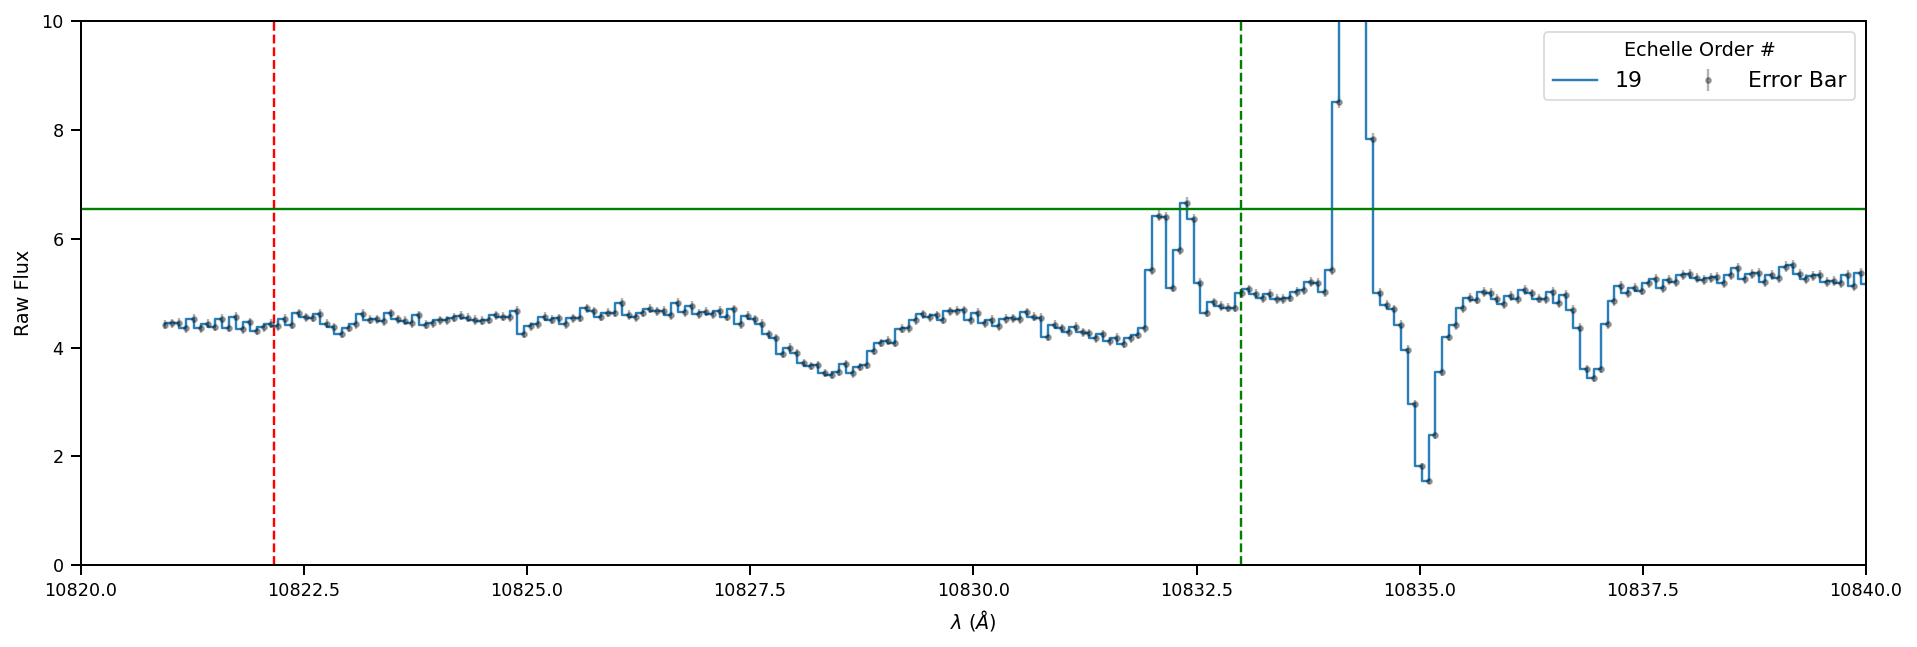

In [17]:
plt.figure(figsize=(16, 5))
order = 19
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(0,10)
plt.xlim(10820,10840)
calcium_line = 10833 #8542 Ca I
wavelength1 = calcium_line*0.999
wavelength2 = calcium_line*1.001
continuum = 6.55
plt.axvline(calcium_line,linestyle='dashed',color='green')
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

Ok, let's fit a model to this data.  The model will consist of a straight-line trend with a Gaussian subtracted from it.  It will have five parameters, the straight-line trend slope $m$ and offset $b$, and the Gaussian amplitude $A$, center wavelength $\mu$, and width $w$.  
$$f_\lambda(m, b, A, \mu, w)= m \lambda +b - A\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

Let's focus on the **sub-region** set by the above plot.

$$f_\lambda(m, b, A, \mu, w)= 1 - \frac{A}{(m \mu + b)}\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

In [ ]:
sub_region = (df.order == order) & (df['Sci Wavl'] > wavelength1) & (df['Sci Wavl'] < wavelength2)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [ ]:
def generative_model(m, b, A, mu, logw, int_wl = calcium_line):
    """Generate the model given parameters"""
    continuum = m * (wl - int_wl) + b
    w = np.exp(logw)
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return continuum - gaussian

Let's make an initial guess.

In [ ]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0.01, 8.4, 3.1, calcium_line, np.log(0.1)

In [ ]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

In [ ]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9', where='mid');
#plt.plot(wl, normalization);
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
#plt.ylim(0,5)

In [ ]:
plt.figure(figsize=(16, 5))
normalization = (wl*0.021)+6.405
plt.step(wl, flux/normalization, label='Data', color='#2980b9');
plt.errorbar(wl, flux/normalization, unc/normalization, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess/normalization, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
#plt.ylim(0,0.1)


The guess is *close* but not perfect-- the line center is slightly off.  That's OK!  Let's use MCMC to fine tune these parameters, and tell us the uncertainty in the parameter values.  We will use [emcee](https://emcee.readthedocs.io/en/stable/).

In [ ]:
import emcee

We need to compute the log likelihood of the data, which takes in the parameters and returns a scalar "quality of fit metric".  Here we use *chi squared*, the sum of the squares of the residuals, weighted by their uncertainties.

In [ ]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = calcium_line)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [ ]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess)

In [ ]:
n_walkers = 32
n_params = 5

In [ ]:
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)

In [ ]:
n_steps = 5000

In [ ]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

In [ ]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
ndim = 5

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
A_draws = samples[2000:, :, 2].reshape(-1)
b_draws = samples[2000:, :, 1].reshape(-1)
m_draws = samples[2000:, :, 0].reshape(-1)
mu_draws = samples[2000:, :, 3].reshape(-1)
w_draws = np.exp(samples[2000:, :, 4].reshape(-1))

Calculate the equivalent width from the MCMC samples.

In [ ]:
m_fit, b_fit, A_fit, mu_fit, w_fit = flat_samples[3912, :]

In [ ]:
good_fit = generative_model(m_fit, b_fit, A_fit, mu_fit, w_fit, int_wl = calcium_line)

In [ ]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model Guess', color='#d35400');
plt.step(wl, good_fit, label='Model fit', color='green');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
#plt.ylim(0,5)

In [ ]:
EW = ((2*np.pi)**.5)*(A_draws*w_draws)/(m_draws*(mu_draws-calcium_line)+b_draws)
EW

In [ ]:
plt.hist(EW, bins = np.arange(0, 0.2, 0.001));
ew_mean = np.mean(EW)
ew_std = np.std(EW)
print(ew_mean)
print(ew_std)

Continue calculating equivalent width for other lines.

In [ ]:
index = 130 # Pick a number in the range (0,410]
fn = goldilocks_files[index]
print (fn)

In [ ]:
%time df = get_goldilocks_dataframe(fn)

In [ ]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(10,14)
plt.xlim(10330,10360)
wavelength1 = 10344
wavelength2 = 10346
continuum = 11.8
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

In [ ]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10343.5) & (df['Sci Wavl'] < 10347)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [ ]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0.04, 11.5, 1.1, 10345, np.log(0.45)

In [ ]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

In [ ]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(10,14)

In [ ]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = 10345)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [ ]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess)

In [ ]:
theta_guess

In [ ]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

In [ ]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Index 130 is breaking, not sure why.

In [ ]:
index = 132 # Pick a number in the range (0,410]
fn = goldilocks_files[index]
print (fn)
%time df = get_goldilocks_dataframe(fn)

In [ ]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(18,22)
plt.xlim(10330,10360)
wavelength1 = 10344
wavelength2 = 10346
continuum = 20.4
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

In [ ]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10343.5) & (df['Sci Wavl'] < 10347)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [ ]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0.01, 20.4, 1.7, 10345, np.log(0.4)

In [ ]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

In [ ]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
#plt.plot(wl, normalization);
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(18,22)

In [ ]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = 10345)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [ ]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess)

In [ ]:
n_walkers = 32
n_params = 5
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)
n_steps = 5000

In [ ]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

In [ ]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
ndim = 5

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
A_draws = samples[2000:, :, 2].reshape(-1)
b_draws = samples[2000:, :, 1].reshape(-1)
m_draws = samples[2000:, :, 0].reshape(-1)
mu_draws = samples[2000:, :, 3].reshape(-1)
w_draws = np.exp(samples[2000:, :, 4].reshape(-1))

In [ ]:
m_fit, b_fit, A_fit, mu_fit, w_fit = flat_samples[3912, :]
good_fit = generative_model(m_fit, b_fit, A_fit, mu_fit, w_fit, int_wl = 10345)

In [ ]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model Guess', color='#d35400');
plt.step(wl, good_fit, label='Model fit', color='green');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(18,22)

In [ ]:
EW = ((2*np.pi)**.5)*(A_draws*w_draws)/(m_draws*(mu_draws-10345)+b_draws)
EW

In [ ]:
plt.hist(EW, bins = np.arange(0.05, 0.13, 0.001));
ew_mean = np.mean(EW)
ew_std = np.std(EW)
print(ew_mean)
print(ew_std)

Index 132 end.

In [ ]:
index = 133 # Pick a number in the range (0,410]
fn = goldilocks_files[index]
print (fn)
%time df = get_goldilocks_dataframe(fn)

In [ ]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(20,27)
plt.xlim(10330,10360)
wavelength1 = 10344
wavelength2 = 10345.8
continuum = 24
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

In [ ]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10343.5) & (df['Sci Wavl'] < 10347)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0.01, 24, 1.8, 10345, np.log(0.4)
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

In [ ]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
#plt.plot(wl, normalization);
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(20,27)

In [ ]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = 10345)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [ ]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess)

In [ ]:
n_walkers = 32
n_params = 5
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)
n_steps = 5000
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

In [ ]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
ndim = 5

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
A_draws = samples[2000:, :, 2].reshape(-1)
b_draws = samples[2000:, :, 1].reshape(-1)
m_draws = samples[2000:, :, 0].reshape(-1)
mu_draws = samples[2000:, :, 3].reshape(-1)
w_draws = np.exp(samples[2000:, :, 4].reshape(-1))

m_fit, b_fit, A_fit, mu_fit, w_fit = flat_samples[3912, :]
good_fit = generative_model(m_fit, b_fit, A_fit, mu_fit, w_fit, int_wl = 10345)

In [ ]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model Guess', color='#d35400');
plt.step(wl, good_fit, label='Model fit', color='green');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(20,27)

In [ ]:
EW = ((2*np.pi)**.5)*(A_draws*w_draws)/(m_draws*(mu_draws-10345)+b_draws)
plt.hist(EW, bins = np.arange(0.05, 0.13, 0.001));
ew_mean = np.mean(EW)
ew_std = np.std(EW)
print(ew_mean)
print(ew_std)